In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

In [2]:
sns.set_style("darkgrid")
sns.set_context("poster")

In [3]:
# Prepare the electricity demand data
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)
df.head()

,Date,Period,OperationalLessIndustrial,Industrial
0,37257,1,3535.867064,1086.132936
1,37257,2,3383.499028,1088.500972
2,37257,3,3655.527552,1084.472448
3,37257,4,3510.446636,1085.553364
4,37257,5,3294.697156,1081.302844


In [4]:
df["Date"] = df["Date"].apply(lambda x:pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1) * 30, unit="m")

In [5]:
df.head()

,Date,Period,OperationalLessIndustrial,Industrial,ds
0,2002-01-01,1,3535.867064,1086.132936,2002-01-01 00:00:00
1,2002-01-01,2,3383.499028,1088.500972,2002-01-01 00:30:00
2,2002-01-01,3,3655.527552,1084.472448,2002-01-01 01:00:00
3,2002-01-01,4,3510.446636,1085.553364,2002-01-01 01:30:00
4,2002-01-01,5,3294.697156,1081.302844,2002-01-01 02:00:00


In [6]:
# resample to hourly and filter for the first 149 days of 2012
data = df[["ds", "OperationalLessIndustrial"]]
data.columns = ["ds", "y"]

start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")

mask = (data["ds"] >= start_date) & (data["ds"] <= end_date)
data = data[mask]

data = data.set_index("ds").resample('h').sum()
data.head()

,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data["day_of_month"] = data.index.day
data["week"] = data.index.isocalendar().week
data["month"] = data.index.month

In [9]:
data.head()

,y,day_of_month,week,month
ds,,,,
2012-01-01 00:00:00,7926.529376,1,52,1
2012-01-01 01:00:00,7901.826990,1,52,1
2012-01-01 02:00:00,7255.721350,1,52,1
2012-01-01 03:00:00,6792.503352,1,52,1
2012-01-01 04:00:00,6635.984460,1,52,1


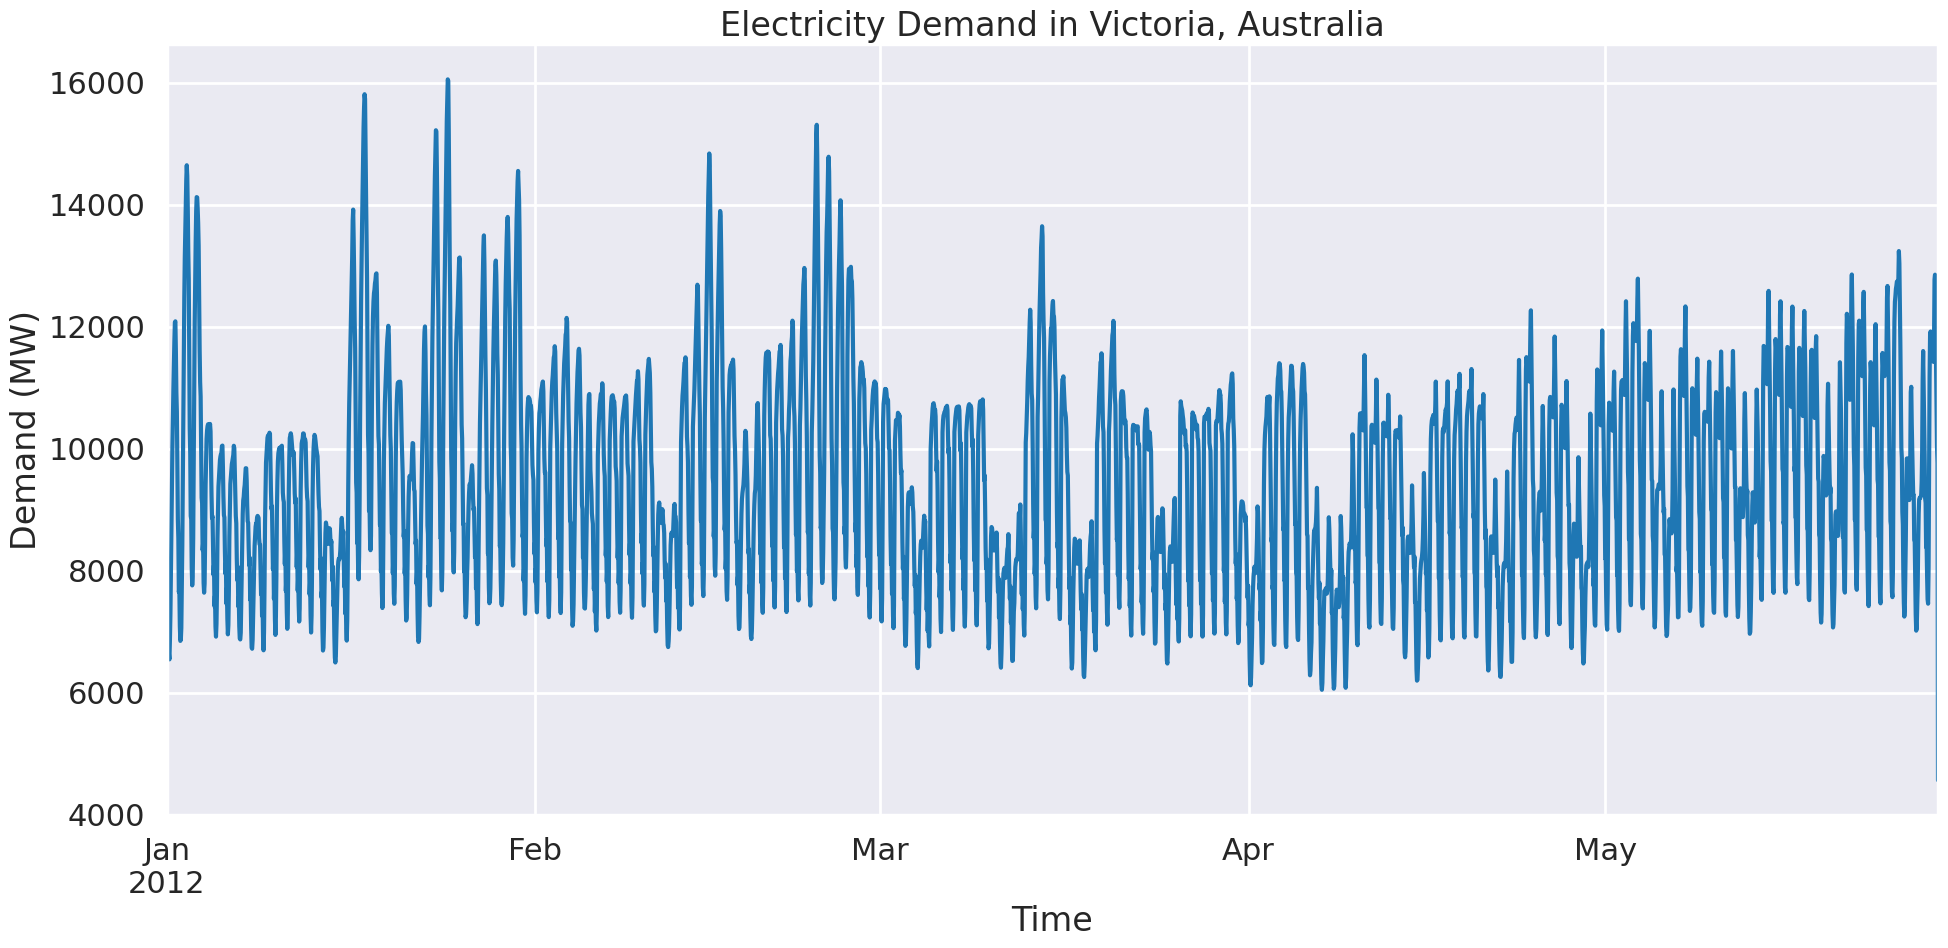

In [10]:
ax = data.plot(y="y", figsize=[20, 10], legend=False)
ax.set(
    xlabel="Time",
    ylabel="Demand (MW)",
    title="Electricity Demand in Victoria, Australia"
)
plt.tight_layout()

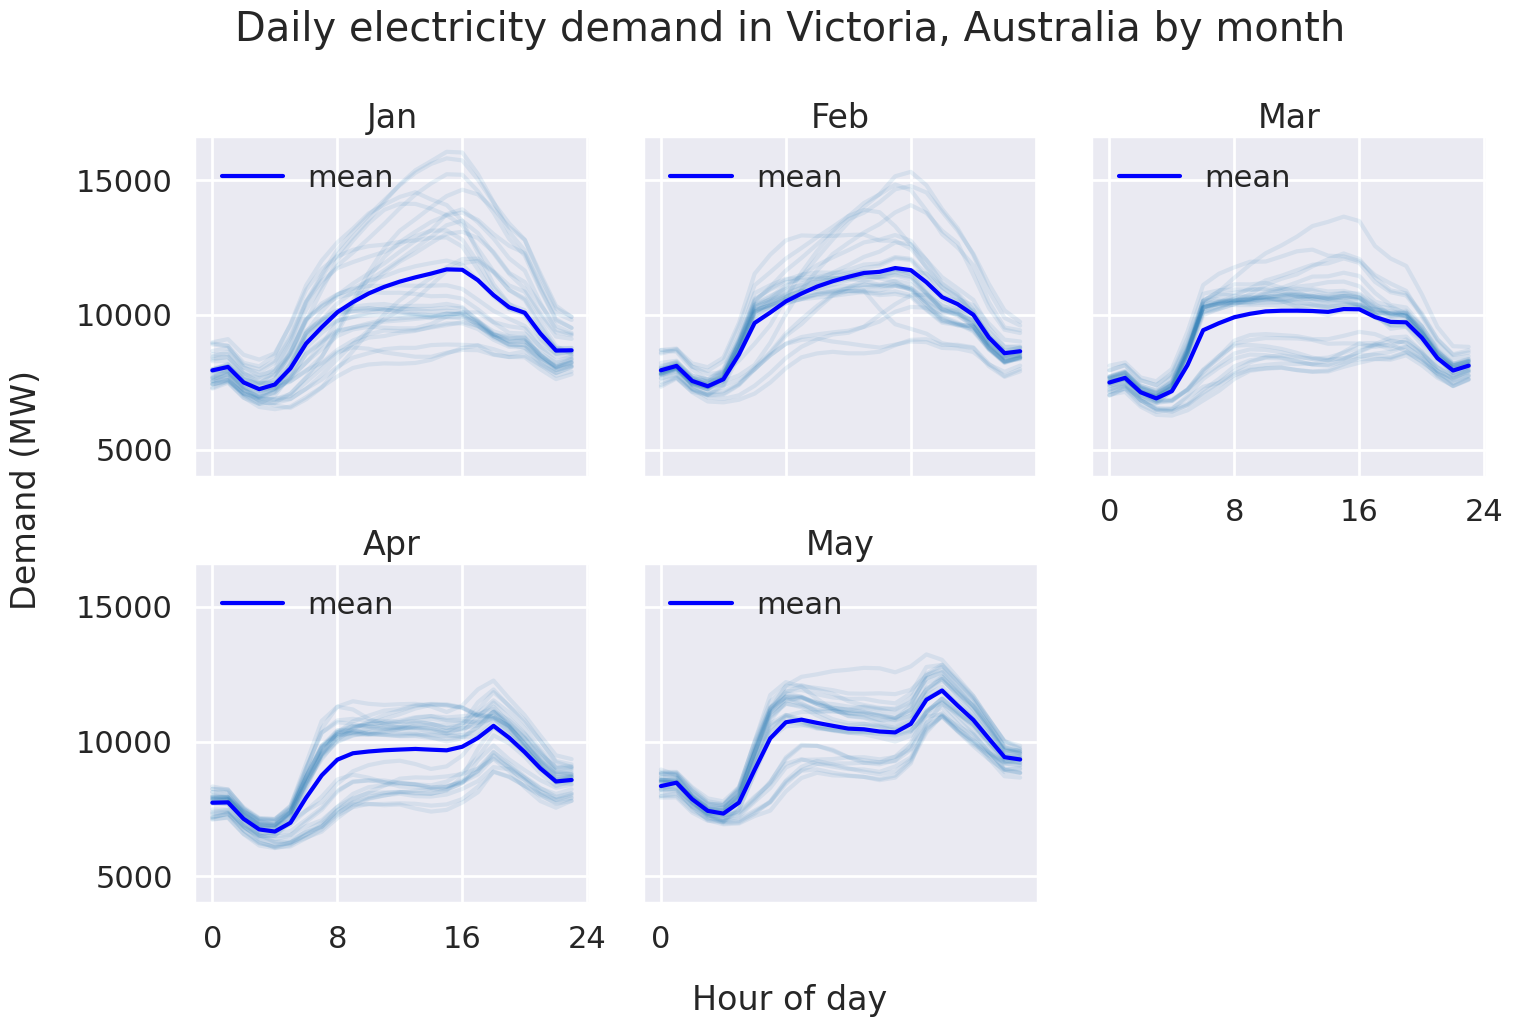

In [11]:
# 1) Set up figure and basic parameters
# Plot the electricity demand for each day
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]
for ix, month in enumerate(MONTHS):

    # Plot individual ts
    daily_ts = []
    for _, ts in (
        data[["y", "day_of_month", "month"]]
        .query(f"month == {ix+1}")
        .groupby("day_of_month")
    ):
        daily_ts.append(ts.reset_index()["y"])
        ts.reset_index()["y"].plot(
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
        )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot the mean ts
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    )
    ax[ix].legend(loc="upper left", frameon=False)

    if month in ("Jan", "Feb"):
        ax[ix].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

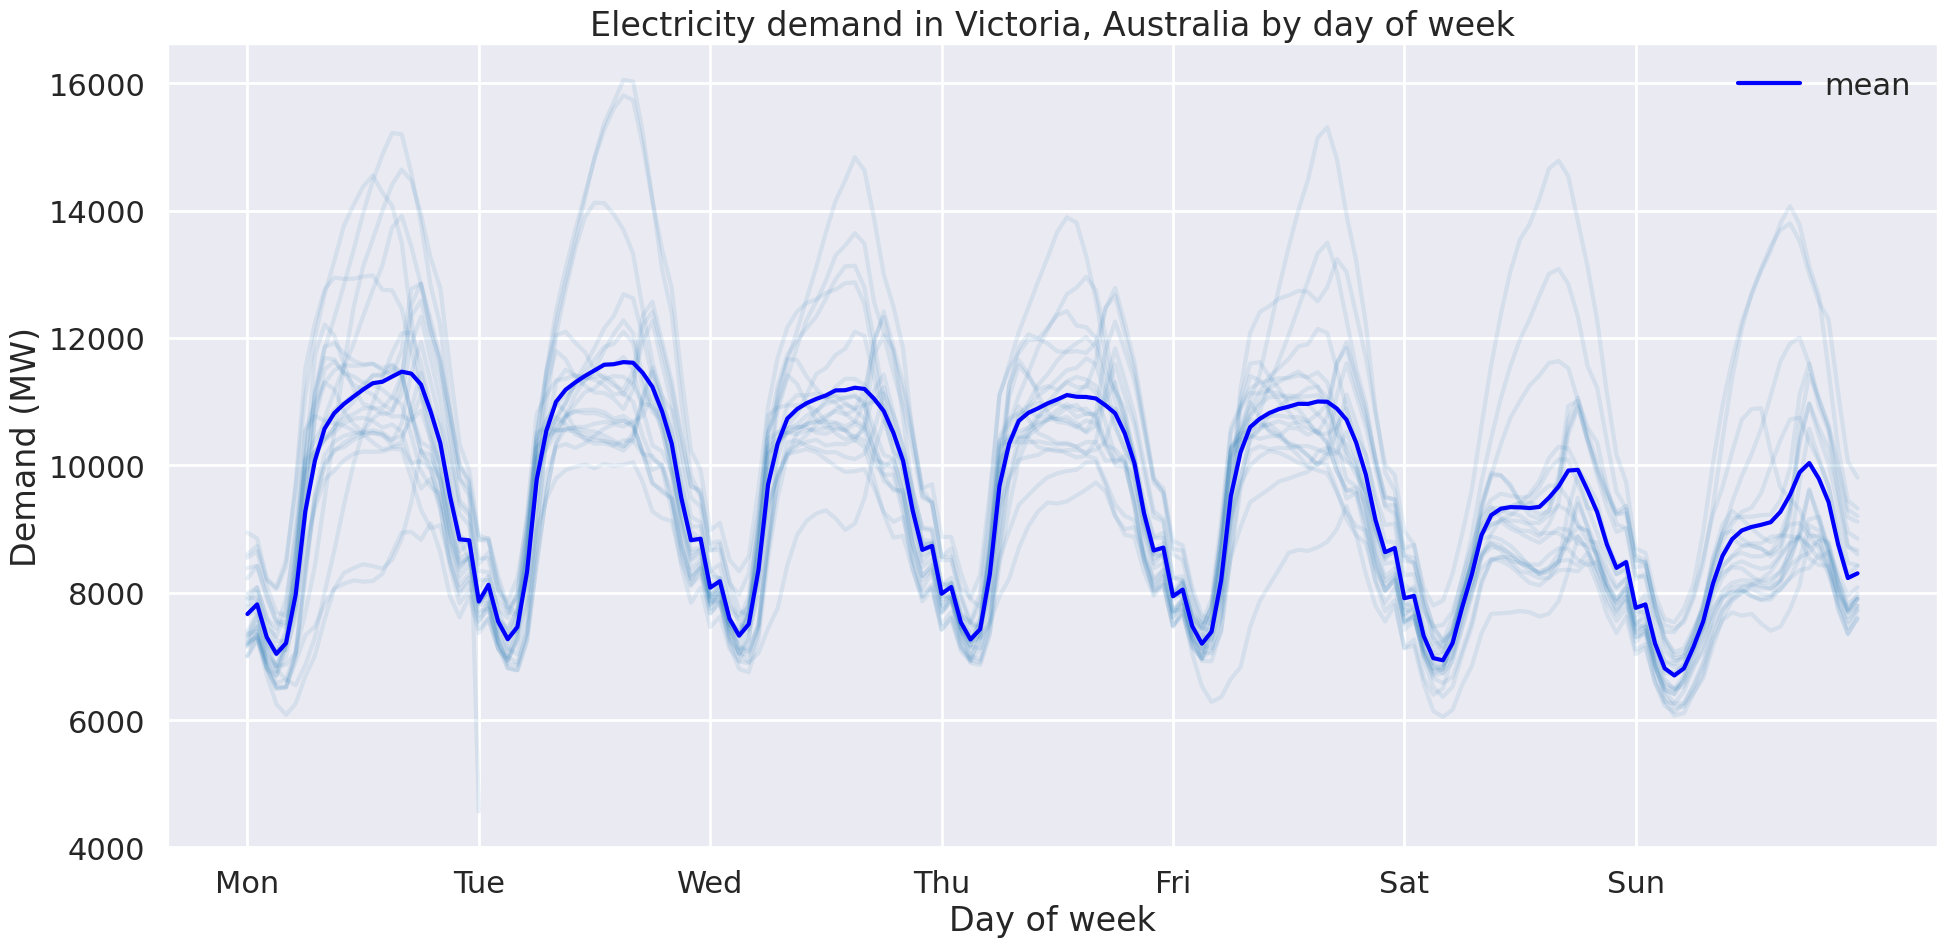

In [12]:
fig, ax = plt.subplots(figsize=[20, 10])
weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)

DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for week, ts in data.groupby("week"):
    weekly_ts.append(ts.reset_index()["y"])
    ts.reset_index()["y"].plot(alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()

In [13]:
mstl = MSTL(data["y"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

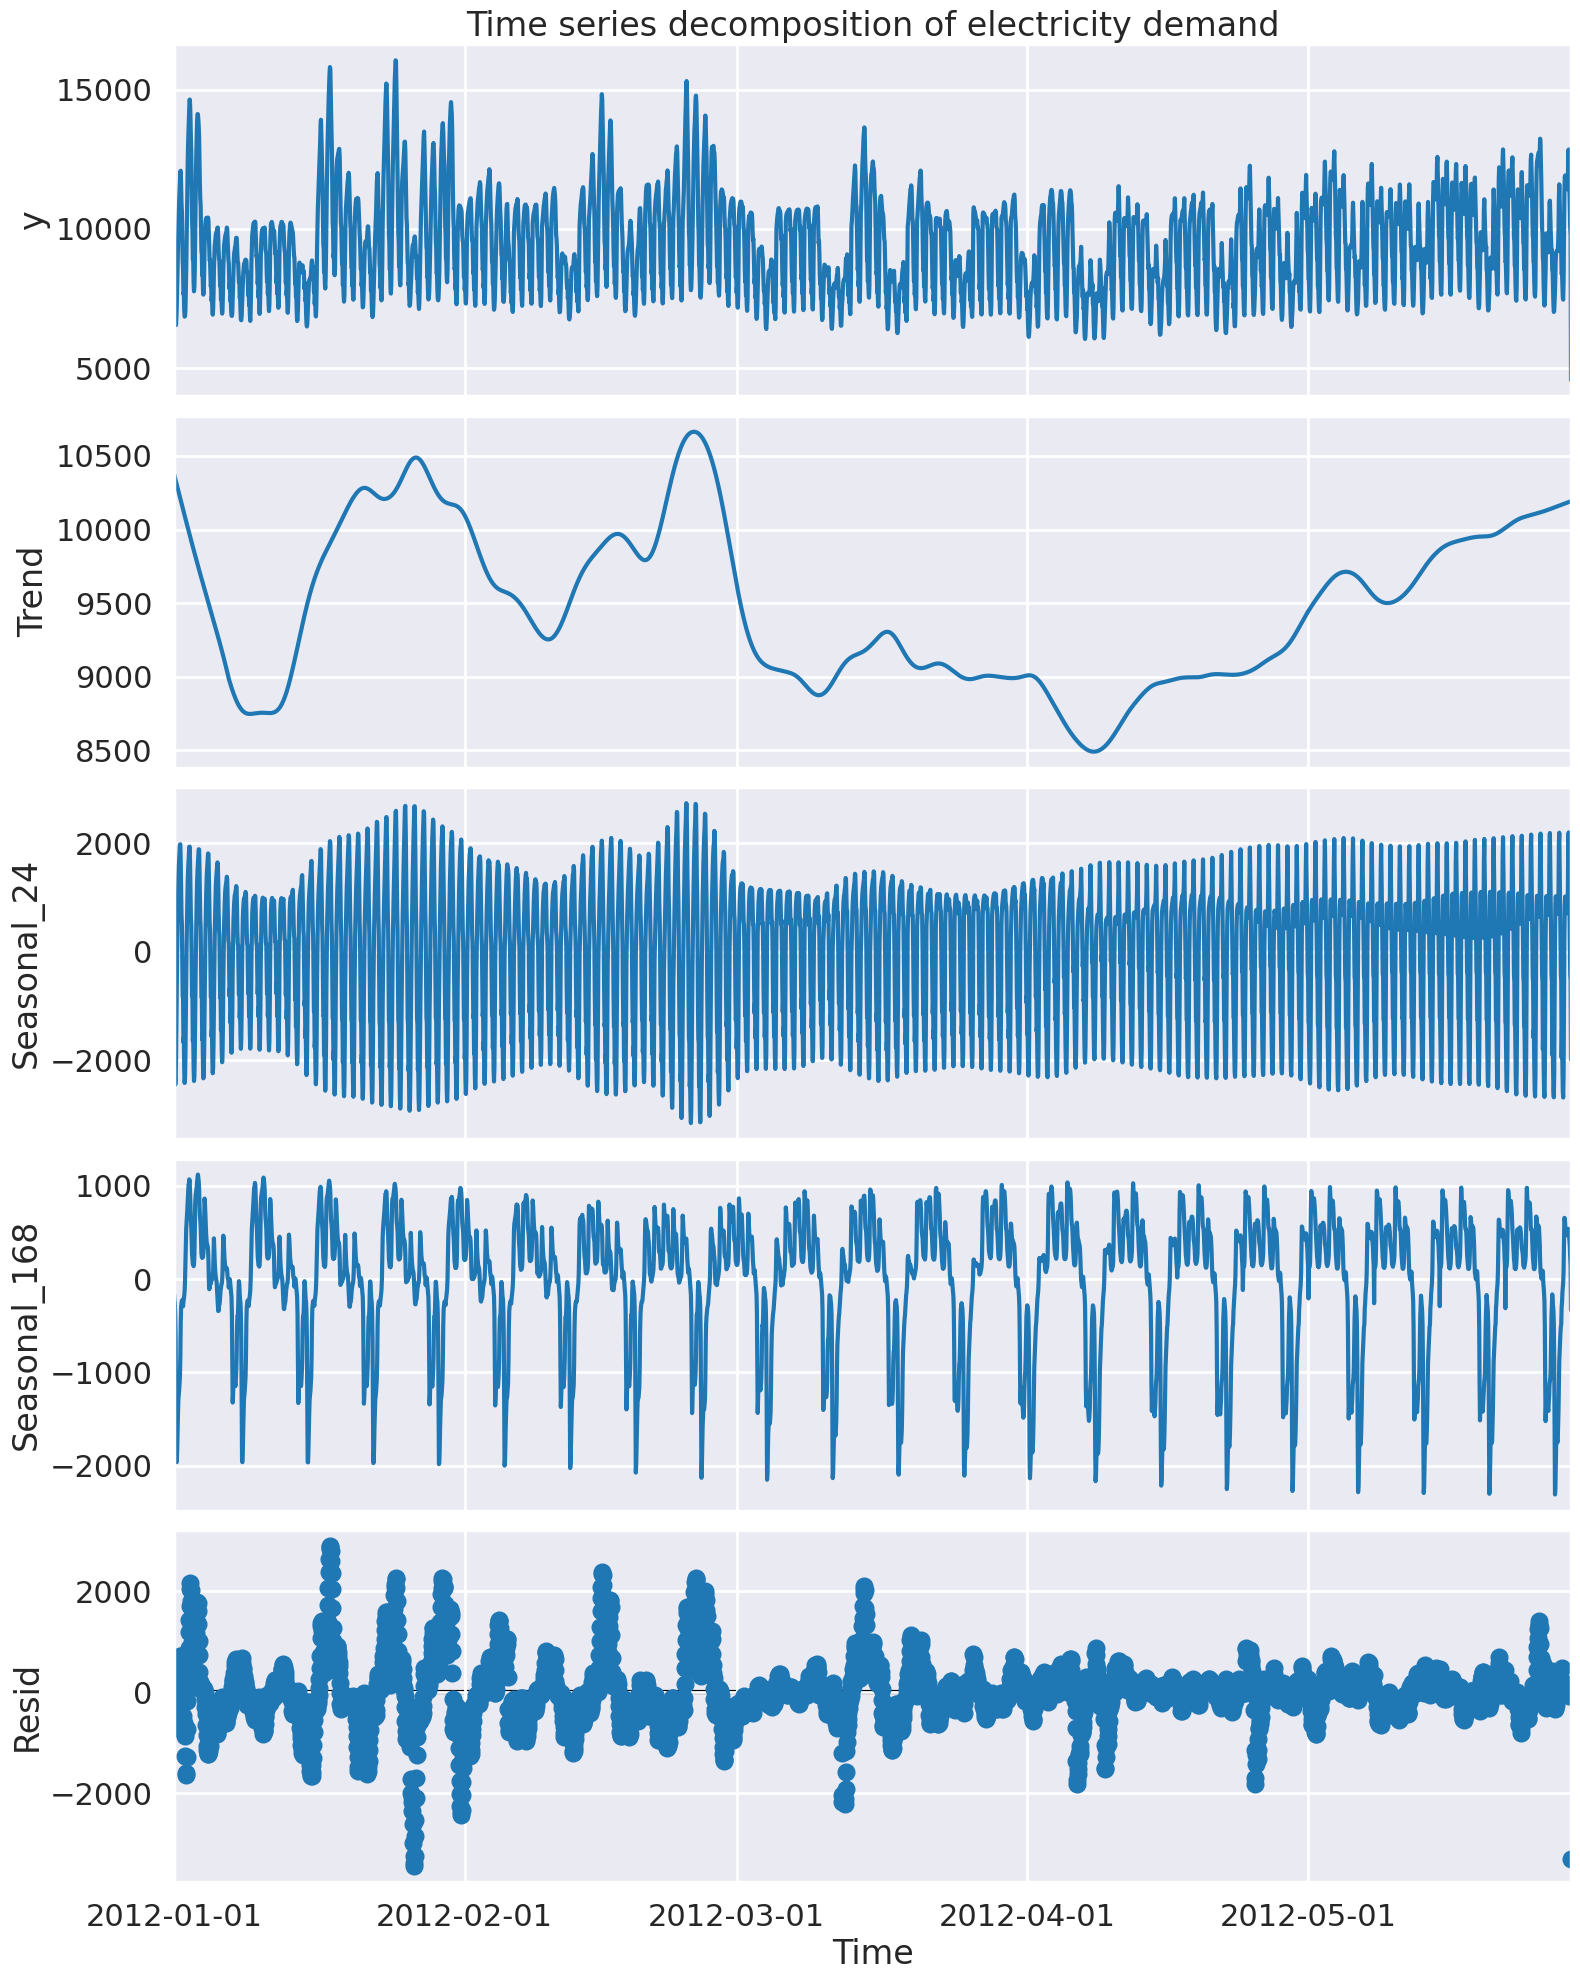

In [15]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")

axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()